# WELL NOTEBOOK
## Well logs visualization &amp; petrophysics

Install the the repository reservoirpy from github and import the required packages

In [1]:
import os
path = os.path.abspath(os.path.join('..','..','..'))
import sys
sys.path.append(path)
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import folium
from pyproj import Proj, transform, CRS, Transformer
from reservoirpy.welllogspy import tracks as tk
from reservoirpy.welllogspy import petrophysics as pt
from reservoirpy.welllogspy.log import log 
from reservoirpy.wellpy import path as ph
from reservoirpy.wellproductivitypy import pi

### Well atributes

Well atributes, name, rte, coordinates, survey

In [2]:
#Create the well object
name = 'well-1'
rte = 515.78 # Rotary table Elevation
surf_coord = Point(1025165.89,1147730.75)
crs = 'EPSG:3117'
deviation = pd.read_csv('survey.csv', header=[0])
print(deviation.head())
print(deviation.tail())

      md   inc    azi
0    0.0  0.00    0.0
1  193.0  0.06    0.0
2  375.0  0.12    0.0
3  559.0  0.33  347.6
4  651.0  0.36  340.5
          md    inc     azi
132  12222.0  18.48  183.46
133  12312.0  18.32  183.53
134  12401.0  18.66  183.58
135  12488.0  19.28  182.83
136  12520.0  19.00  182.50


### Well Tops 

Data table of the tentative formation well tops from masterlog

In [3]:
#Tentative Formations Tops
tops = ph.tops([['fm1',0,7580],
         ['fm2',7581,8868],
         ['fm1',8869,9474],
         ['fm2',9475,9690],
         ['fm3',9691,9924],
         ['fm4',9925,9994],
         ['fm5',9995,10557],
         ['fm6',10558,10798],
         ['fm7',10799,11108],
         ['fm8',11109,11288],
         ['fm9',11289,11317,20,170,1.5],
         ['fm10',11318,11965,10,170,2],
         ['fm11',11966,12080,50,190,0.12],
         ['fm12',12081,12222,50,190,0.12],
         ['fm13',12223,12233,50,190,0.1],
         ['fm14',12234,12520,15,170,0.1]], 
         columns=['formation','md_top','md_bottom','gr_sand','gr_shale','rw'])
tops

,md_top,md_bottom,gr_sand,gr_shale,rw
formation,,,,,
fm1,0,7580,NaN,NaN,NaN
fm2,7581,8868,NaN,NaN,NaN
fm1,8869,9474,NaN,NaN,NaN
fm2,9475,9690,NaN,NaN,NaN
fm3,9691,9924,NaN,NaN,NaN
fm4,9925,9994,NaN,NaN,NaN
fm5,9995,10557,NaN,NaN,NaN
fm6,10558,10798,NaN,NaN,NaN
fm7,10799,11108,NaN,NaN,NaN


In [4]:
tops.get_mid_point()

,md_top,md_bottom,gr_sand,gr_shale,rw,md_mid_point
formation,,,,,,
fm1,0,7580,NaN,NaN,NaN,3790.0
fm2,7581,8868,NaN,NaN,NaN,8224.5
fm1,8869,9474,NaN,NaN,NaN,9171.5
fm2,9475,9690,NaN,NaN,NaN,9582.5
fm3,9691,9924,NaN,NaN,NaN,9807.5
fm4,9925,9994,NaN,NaN,NaN,9959.5
fm5,9995,10557,NaN,NaN,NaN,10276.0
fm6,10558,10798,NaN,NaN,NaN,10678.0
fm7,10799,11108,NaN,NaN,NaN,10953.5


### Import the logs
Import the masterlog and openhole log

In [5]:
# list of mnemonics 
#mn = pd.read_csv('mnemonics.csv')

#Upload logs
masterlog = log('master.las')
openlog = log('logs.las', find_mnemonics=True)

Header section Parameter regexp=~P was not found.
Header section Parameter regexp=~P was not found.


Mnemonic:  ROPA  =>  ROP_ROPA
Mnemonic:  AFRMC  =>  RM_AFRMC
Mnemonic:  AFRSC  =>  RS_AFRSC
Mnemonic:  AFRDC  =>  RD_AFRDC
Mnemonic:  ALCDLC  =>  RHOB_ALCDLC
Mnemonic:  ALDCLC  =>  DCOR_ALDCLC
Mnemonic:  ALPELC  =>  PEF_ALPELC
Mnemonic:  TNPS  =>  NPHI_TNPS


## Create the well with its atributes

In [6]:
#Create the well
b2 = ph.well(name='well-1', 
             rte=rte, 
             surf_coord=surf_coord, 
             crs=crs, 
             survey=deviation, 
             tops=tops, 
             masterlog=masterlog, 
             openlog=openlog)

### Methods

Once the well is created with its attributes multiple operations can be made:
- Estimate Survey
- Make sample deviation and sample position
- Convert md to Tvd, Tvdss, Coord
- Assign formations depth to logs depending on the well tops



### Survey

By using the minimumm curvature ratio it estimates the Tvd, Northing, Easting and dogleg. 
the method also create the Point Shape object for each point

In [7]:
b2.survey

,inc,azi,tvd,tvdss,north_offset,east_offset,northing,easting,dleg,geometry
md,,,,,,,,,,
0.0,0.00,0.00,0.000000,515.780000,0.000000,0.000000,1.147731e+06,1.025166e+06,0.000000,POINT (1025165.890 1147730.750)
193.0,0.06,0.00,192.999965,322.780035,0.101055,0.000000,1.147731e+06,1.025166e+06,0.031088,POINT (1025165.890 1147730.781)
375.0,0.12,0.00,374.999732,140.780268,0.386939,0.000000,1.147731e+06,1.025166e+06,0.032967,POINT (1025165.890 1147730.868)
559.0,0.33,347.60,558.998219,-43.218219,1.097142,-0.113784,1.147731e+06,1.025166e+06,0.116497,POINT (1025165.855 1147731.084)
651.0,0.36,340.50,650.996554,-135.216554,1.628348,-0.267154,1.147731e+06,1.025166e+06,0.056709,POINT (1025165.809 1147731.246)
...,...,...,...,...,...,...,...,...,...,...
12222.0,18.48,183.46,11979.483886,-11463.703886,-1513.062040,-87.705754,1.147270e+06,1.025139e+06,0.422310,POINT (1025139.157 1147269.569)
12312.0,18.32,183.53,12064.882700,-11549.102700,-1541.417598,-89.437497,1.147261e+06,1.025139e+06,0.179465,POINT (1025138.629 1147260.926)
12401.0,18.66,183.58,12149.288309,-11633.508309,-1569.588577,-91.187763,1.147252e+06,1.025138e+06,0.382438,POINT (1025138.096 1147252.339)


### Convert Coordinates system
You can easily convert to other coordinate system for map plotting

In [8]:
b2.survey.to_crs("EPSG:4326").head()

,inc,azi,tvd,tvdss,north_offset,east_offset,northing,easting,dleg,geometry
md,,,,,,,,,,
0.0,0.00,0.0,0.000000,515.780000,0.000000,0.000000,1.147731e+06,1.025166e+06,0.000000,POINT (-70.85023 5.93207)
193.0,0.06,0.0,192.999965,322.780035,0.101055,0.000000,1.147731e+06,1.025166e+06,0.031088,POINT (-70.85023 5.93207)
375.0,0.12,0.0,374.999732,140.780268,0.386939,0.000000,1.147731e+06,1.025166e+06,0.032967,POINT (-70.85023 5.93207)
559.0,0.33,347.6,558.998219,-43.218219,1.097142,-0.113784,1.147731e+06,1.025166e+06,0.116497,POINT (-70.85023 5.93208)
651.0,0.36,340.5,650.996554,-135.216554,1.628348,-0.267154,1.147731e+06,1.025166e+06,0.056709,POINT (-70.85023 5.93208)


### Transform the coordinates and mapping

In [9]:
#Transform the Surface Coordinate from EPSG:3117 to 4326
print(b2.surf_coord.wkt)
tr = Transformer.from_crs("EPSG:3117", "EPSG:4326",always_xy=True)
x2,y2 = tr.transform(b2.surf_coord.x, b2.surf_coord.y)
p_4326 = Point(x2,y2)

print(p_4326.wkt)

#surv_geojson = b2.survey.to_crs("EPSG:4326").to_json()

#Map
m = folium.Map(location=[p_4326.y,p_4326.x],zoom_start=15)
folium.Marker([p_4326.y, p_4326.x], popup='well-1').add_to(m)
#folium.GeoJson(surv_geojson,name='survey').add_to(m)
m

POINT (1025165.89 1147730.75)
POINT (-70.85023050412562 5.932072054847613)


### Resample Survey 

You can resample the deviation and position according to a given step size

In [10]:
#Sample Deviation
b2.sample_deviation(step=2000)

,new_md,new_inc,new_azi
0,0.0,0.000000,0.000000
1,2000.0,1.580000,245.030000
2,4000.0,0.874000,236.590667
3,6000.0,0.223418,298.941772
4,8000.0,13.762247,185.769888
5,10000.0,19.143667,185.485000
6,12000.0,19.098090,182.625056
7,12520.0,19.000000,182.500000


In [11]:
#Sample Position
b2.sample_position(step=1000)

,new_tvd,new_easting,new_northing,geometry
0,0.000000,1.025166e+06,1.147731e+06,POINT (1025165.890 1147730.750)
1,1000.000000,1.025166e+06,1.147732e+06,POINT (1025166.052 1147731.607)
2,2000.000000,1.025168e+06,1.147732e+06,POINT (1025167.896 1147731.890)
3,3000.000000,1.025164e+06,1.147734e+06,POINT (1025164.082 1147734.440)
4,4000.000000,1.025168e+06,1.147733e+06,POINT (1025167.686 1147732.916)
5,5000.000000,1.025166e+06,1.147731e+06,POINT (1025165.649 1147731.295)
6,6000.000000,1.025165e+06,1.147730e+06,POINT (1025165.444 1147730.355)
7,7000.000000,1.025163e+06,1.147727e+06,POINT (1025163.041 1147727.404)
8,8000.000000,1.025160e+06,1.147688e+06,POINT (1025159.885 1147687.940)
9,9000.000000,1.025155e+06,1.147588e+06,POINT (1025154.719 1147587.689)


In [12]:
surv_geojson = b2.sample_position(step=1500).to_crs("EPSG:4326").to_json()

#Map
m = folium.Map(location=[p_4326.y,p_4326.x],zoom_start=16)
folium.Marker([p_4326.y, p_4326.x], popup='Well-1').add_to(m)
folium.GeoJson(surv_geojson,name='survey').add_to(m)
m

### Function to convert easily md to tvd, tvdss, and coord

In [13]:
depth = [10525,9000,12000]

d_tvd = b2.to_tvd(md=depth)
d_tvdss = b2.to_tvd(md=depth,ss=True)

print(type(d_tvd))
print(d_tvdss)

<class 'numpy.ndarray'>
[ -9859.49467578  -8423.67761758 -11253.25947642]


In [14]:
depth = 10525

d_tvd = b2.to_tvd(md=depth)
d_tvdss = b2.to_tvd(md=depth,ss=True)
d_coord = b2.to_coord(md=depth)

print(f"From {depth} md to: \n  {d_tvd} tvd \n  {d_tvdss} tvdss \n  {d_coord.wkt}")

From 10525 md to: 
  10375.274675782086 tvd 
  -9859.494675782085 tvdss 
  POINT (1025146.067017453 1147438.041069868)


## Get the tvd tvdss and coord of formation well tops

In [15]:
b2.to_tvd(which=['tops'])
b2.tops

,md_top,md_bottom,gr_sand,gr_shale,rw,md_mid_point,tvd_top,tvd_bottom,tvd_tick
formation,,,,,,,,,
fm1,0,7580,NaN,NaN,NaN,3790.0,0.000000,7576.968659,7576.968659
fm2,7581,8868,NaN,NaN,NaN,8224.5,7577.959424,8815.043031,1237.083607
fm1,8869,9474,NaN,NaN,NaN,9171.5,8815.986710,9384.503530,568.516820
fm2,9475,9690,NaN,NaN,NaN,9582.5,9385.439216,9587.327616,201.888401
fm3,9691,9924,NaN,NaN,NaN,9807.5,9588.270350,9808.012772,219.742422
fm4,9925,9994,NaN,NaN,NaN,9959.5,9808.956914,9874.105778,65.148864
fm5,9995,10557,NaN,NaN,NaN,10276.0,9875.050125,10405.553960,530.503835
fm6,10558,10798,NaN,NaN,NaN,10678.0,10406.500187,10633.521496,227.021309
fm7,10799,11108,NaN,NaN,NaN,10953.5,10634.464425,10926.290651,291.826227


In [16]:
b2.to_tvd(which=['tops'], ss=True)
b2.tops

,md_top,md_bottom,gr_sand,gr_shale,rw,md_mid_point,tvd_top,tvd_bottom,tvd_tick,tvdss_top,tvdss_bottom
formation,,,,,,,,,,,
fm1,0,7580,NaN,NaN,NaN,3790.0,0.000000,7576.968659,7576.968659,515.780000,-7061.188659
fm2,7581,8868,NaN,NaN,NaN,8224.5,7577.959424,8815.043031,1237.083607,-7062.179424,-8299.263031
fm1,8869,9474,NaN,NaN,NaN,9171.5,8815.986710,9384.503530,568.516820,-8300.206710,-8868.723530
fm2,9475,9690,NaN,NaN,NaN,9582.5,9385.439216,9587.327616,201.888401,-8869.659216,-9071.547616
fm3,9691,9924,NaN,NaN,NaN,9807.5,9588.270350,9808.012772,219.742422,-9072.490350,-9292.232772
fm4,9925,9994,NaN,NaN,NaN,9959.5,9808.956914,9874.105778,65.148864,-9293.176914,-9358.325778
fm5,9995,10557,NaN,NaN,NaN,10276.0,9875.050125,10405.553960,530.503835,-9359.270125,-9889.773960
fm6,10558,10798,NaN,NaN,NaN,10678.0,10406.500187,10633.521496,227.021309,-9890.720187,-10117.741496
fm7,10799,11108,NaN,NaN,NaN,10953.5,10634.464425,10926.290651,291.826227,-10118.684425,-10410.510651


In [17]:
b2.to_coord(which=['tops'])
b2.tops

,md_top,md_bottom,gr_sand,gr_shale,rw,md_mid_point,tvd_top,tvd_bottom,tvd_tick,tvdss_top,tvdss_bottom,northing,easting,geometry
formation,,,,,,,,,,,,,,
fm1,0,7580,NaN,NaN,NaN,3790.0,0.000000,7576.968659,7576.968659,515.780000,-7061.188659,1.147731e+06,1.025166e+06,POINT (1025165.89 1147730.75)
fm2,7581,8868,NaN,NaN,NaN,8224.5,7577.959424,8815.043031,1237.083607,-7062.179424,-8299.263031,1.147713e+06,1.025162e+06,POINT (1025162.274375075 1147712.78918759)
fm1,8869,9474,NaN,NaN,NaN,9171.5,8815.986710,9384.503530,568.516820,-8300.206710,-8868.723530,1.147608e+06,1.025156e+06,POINT (1025156.074289279 1147607.61993497)
fm2,9475,9690,NaN,NaN,NaN,9582.5,9385.439216,9587.327616,201.888401,-8869.659216,-9071.547616,1.147545e+06,1.025152e+06,POINT (1025152.471288808 1147544.575232451)
fm3,9691,9924,NaN,NaN,NaN,9807.5,9588.270350,9808.012772,219.742422,-9072.490350,-9292.232772,1.147522e+06,1.025151e+06,POINT (1025150.753199709 1147522.011942269)
fm4,9925,9994,NaN,NaN,NaN,9959.5,9808.956914,9874.105778,65.148864,-9293.176914,-9358.325778,1.147498e+06,1.025150e+06,POINT (1025149.50473426 1147498.332263628)
fm5,9995,10557,NaN,NaN,NaN,10276.0,9875.050125,10405.553960,530.503835,-9359.270125,-9889.773960,1.147491e+06,1.025149e+06,POINT (1025148.978662995 1147491.325038694)
fm6,10558,10798,NaN,NaN,NaN,10678.0,10406.500187,10633.521496,227.021309,-9890.720187,-10117.741496,1.147435e+06,1.025146e+06,POINT (1025145.967594554 1147434.788706998)
fm7,10799,11108,NaN,NaN,NaN,10953.5,10634.464425,10926.290651,291.826227,-10118.684425,-10410.510651,1.147411e+06,1.025146e+06,POINT (1025145.506021991 1147410.963127096)


In [18]:
b2.tops.head()

,md_top,md_bottom,gr_sand,gr_shale,rw,md_mid_point,tvd_top,tvd_bottom,tvd_tick,tvdss_top,tvdss_bottom,northing,easting,geometry
formation,,,,,,,,,,,,,,
fm1,0,7580,NaN,NaN,NaN,3790.0,0.000000,7576.968659,7576.968659,515.780000,-7061.188659,1.147731e+06,1.025166e+06,POINT (1025165.890 1147730.750)
fm2,7581,8868,NaN,NaN,NaN,8224.5,7577.959424,8815.043031,1237.083607,-7062.179424,-8299.263031,1.147713e+06,1.025162e+06,POINT (1025162.274 1147712.789)
fm1,8869,9474,NaN,NaN,NaN,9171.5,8815.986710,9384.503530,568.516820,-8300.206710,-8868.723530,1.147608e+06,1.025156e+06,POINT (1025156.074 1147607.620)
fm2,9475,9690,NaN,NaN,NaN,9582.5,9385.439216,9587.327616,201.888401,-8869.659216,-9071.547616,1.147545e+06,1.025152e+06,POINT (1025152.471 1147544.575)
fm3,9691,9924,NaN,NaN,NaN,9807.5,9588.270350,9808.012772,219.742422,-9072.490350,-9292.232772,1.147522e+06,1.025151e+06,POINT (1025150.753 1147522.012)


### Assign to each depth of the logs a Formation according to tops

In [19]:
b2.tops_to_logs(which=['masterlog','openlog'])

In [20]:
b2.to_tvd(which=['masterlog','openlog'])

In [21]:
b2.masterlog.df().head()

,ROPA,HYDC1,METH1,ETH1,PRP1,IBUT1,NBUT1,IPEN1,NPEN1,CO2_1,H2S2,LFL2,formation,tvd,tvdss
DMEA,,,,,,,,,,,,,,,
47.0,534.0000,1.478,0.0,0.0,0.0,0.0,0.289,0.366,0.823,465.605,2.0801,0.0,fm1,46.999991,468.780009
48.0,73.4694,1.478,0.0,0.0,0.0,0.0,0.289,0.366,0.823,465.605,0.0000,0.0,fm1,47.999991,467.780009
49.0,90.9474,1.478,0.0,0.0,0.0,0.0,0.289,0.366,0.823,465.605,0.7377,0.0,fm1,48.999991,466.780009
50.0,120.7742,1.478,0.0,0.0,0.0,0.0,0.289,0.366,0.823,465.605,0.6247,0.0,fm1,49.999991,465.780009
51.0,162.0000,1.478,0.0,0.0,0.0,0.0,0.289,0.366,0.823,465.605,2.0203,0.0,fm1,50.999991,464.780009


In [22]:
b2.openlog.df().tail()

,ROP_ROPA,DGRCC,R09PC,R15PC,R27PC,R39PC,ARH16PC,ARH32PC,ARH48PC,ARM48PC,...,ABR,RHOB_ALCDLC,DCOR_ALDCLC,PEF_ALPELC,NPHI_TNPS,ALHSI,STEMP,formation,tvd,tvdss
DEPT,,,,,,,,,,,,,,,,,,,,,
12519.25,24.8921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.9662,NaN,NaN,NaN,NaN,NaN,NaN,fm14,12261.085454,-11745.305454
12519.50,24.8910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.9404,NaN,NaN,NaN,NaN,NaN,NaN,fm14,12261.321634,-11745.541634
12519.75,24.8984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.8914,NaN,NaN,NaN,NaN,NaN,NaN,fm14,12261.557814,-11745.777814
12520.00,23.9366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.8251,NaN,NaN,NaN,NaN,NaN,NaN,fm14,12261.793994,-11746.013994
12520.25,23.3663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.8010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12262.030174,-11746.250174


### Logs Visualization
Plot the initial curves since the 

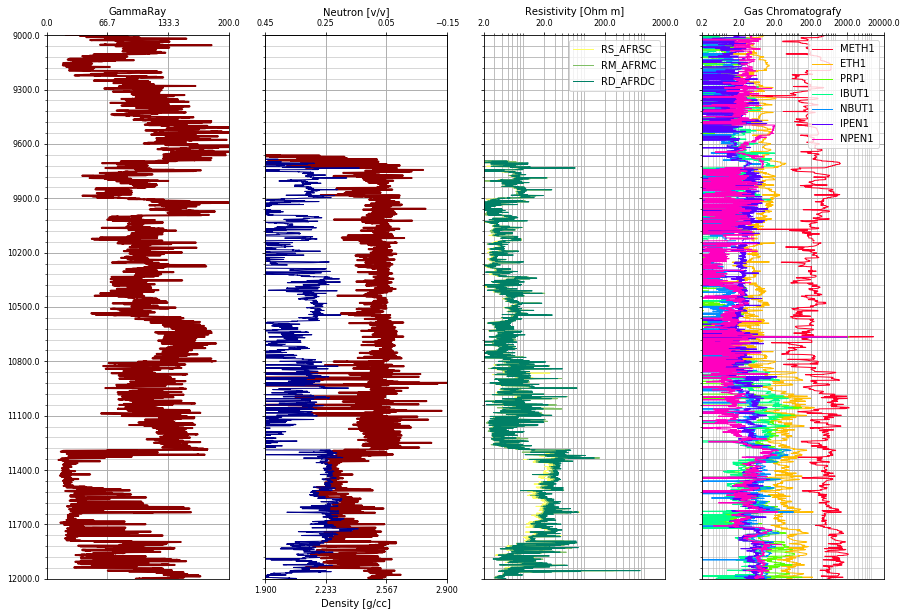

In [23]:

logs = b2.openlog.df()
master = b2.masterlog.df()

From = 9000
To = 12000

fig, ax = plt.subplots(1,4, figsize=(15,10))

tk.grtrack(logs,gr='DGRCC', gr_max=200, ax=ax[0], lims=[From,To])
tk.dntrack(logs,rho='RHOB_ALCDLC',ntr='NPHI_TNPS', ax=ax[1],lims=[From,To])
tk.restrack(logs, res=['RS_AFRSC', 'RM_AFRMC', 'RD_AFRDC'], ax=ax[2], res_range=[2,2000],lims=[From,To])
tk.gastrack(master, gas=['METH1', 'ETH1', 'PRP1', 'IBUT1', 'NBUT1', 'IPEN1','NPEN1'], ax=ax[3],lims=[From,To])

### Add formations tops 

In [24]:
dict(linewidth=1)

{'linewidth': 1}

In [25]:
pd.DataFrame({'depth':[12250],'comment':["Gas comment"]})

,depth,comment
0,12250,Gas comment


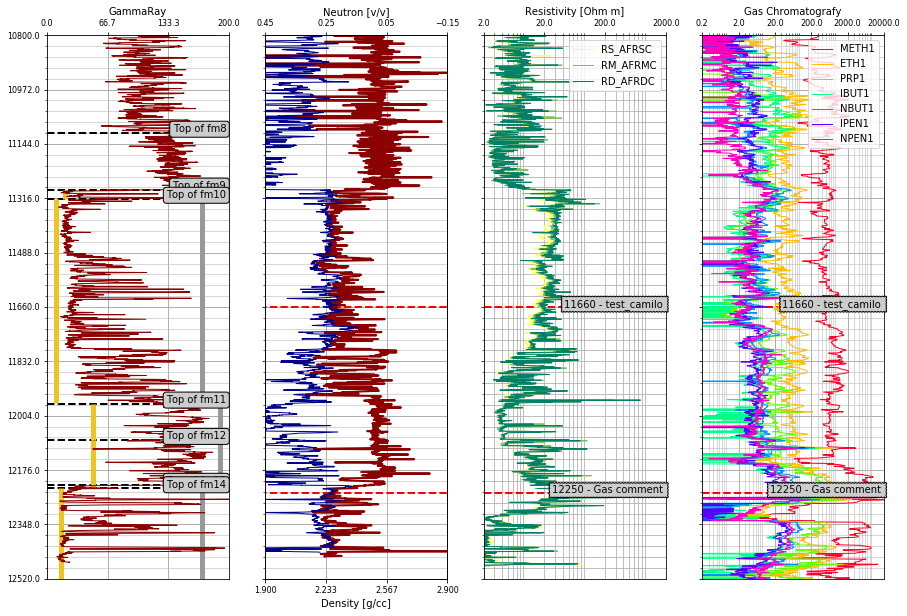

In [26]:
anot = pd.DataFrame({'depth':[12250,11660],'comment':["Gas comment",'test_camilo']})

tops = b2.tops

From = 10800
To = 12520

fig, ax = plt.subplots(1,4, figsize=(15,10))

tk.grtrack(logs,gr='DGRCC', gr_max=200, ax=ax[0], gr_sand_shale = tops, fm = tops,
           fm_kw={'ann':True,'color':'black', 'linewidth':2, 'linestyle':'--'}, 
           gr_kw=dict(linewidth=1), 
           gr_sand_kw={'linewidth':5, 'color':(237/255,196/255,33/255)},
           gr_shale_kw={'linewidth':5, 'color':(0.6,0.6,0.6)},lims=[From,To] )


tk.dntrack(logs,rho='RHOB_ALCDLC',ntr='NPHI_TNPS', ax=ax[1],correlation=anot,lims=[From,To])
tk.restrack(logs, res=['RS_AFRSC', 'RM_AFRMC', 'RD_AFRDC'], ax=ax[2], res_range=[2,2000],correlation=anot,corr_kw={'ann':True},lims=[From,To])
tk.gastrack(master, gas=['METH1', 'ETH1', 'PRP1', 'IBUT1', 'NBUT1', 'IPEN1','NPEN1'], ax=ax[3], correlation=anot,corr_kw={'ann':True},lims=[From,To])

## Petrophysical calculation

### Petrophysical Funcitons

In [27]:
# Vshale

pt.vshale_gr([180,150,20,250,5],10,200, type='linear')
pt.vshale_dn(2.5,0.2, rho_ma=2.71)

array([0.2605606])

In [28]:
# Porosity Functions

#Porosity from Density
pt.phi_rho(2.34,rho_ma=2.65,rho_f=1)

#Average Porosity
pt.phia(0.2,0.3,method='geometric')

#Effective Porosity
pt.phie([0.2,0.25],0.2)




array([0.16, 0.2 ])

In [29]:
#Saturations

pt.sw([900,800,700,1000],0.16,1.2,vsh_curve=0.2,a=0.81, m=2, n=2, method='indo')



array([0.11915398, 0.12638188, 0.13510792, 0.11303939])

In [30]:
# Depth temperature

pt.depth_temperature(10000,surface_temperature=77 ,gradient=1)

array([177.])

In [31]:
# Water resistivity temperature

pt.rw_temp_convert(1.2,77,180, temp_unit='f')

pt.rw(177, 10000,temp_unit='f')

pt.rw2(177, 10000, verbose=False,Celcius=False)

0.24877226501587013

In [32]:
# Permeability

pt.perm([0.16,0.1],0.15,fluid='oil',author='coates')

array([37.13706667,  5.66666667])

In [33]:
# Flow capacity

pt.flow_capacity(10,[40,60,50],1)


(array([400, 600, 500]), array([0.73333333, 0.33333333, 0.        ]))

In [34]:
logpt = pd.DataFrame()
for i in b2.tops.iterrows():

    logv = pt.petrophysics(logs,i[1]['md_top'],i[1]['md_bottom'],
                           vshale_gr_kw=dict(vsh_col_name='vsh_gr', gr_name='DGRCC', gr_sand=i[1]['gr_sand'], gr_shale = i[1]['gr_shale']),
                           vshale_dn_kw=dict(vsh_col_name='vsh_dn', rho_name='RHOB_ALCDLC',ntr_name='NPHI_TNPS'),
                           phi_rho_kw=dict(phi_rho_name='phi_rho', rho_name='RHOB_ALCDLC', rho_ma=2.65),
                           phie_kw=dict(phi_rho_name='phi_rho',ntr_name='NPHI_TNPS', vsh_name='vsh_dn'),
                           sw_kw=dict(rt_name='RD_AFRDC',phi_name='phie_avg',vsh_name='vsh_dn', rw=i[1]['rw'], methods=['archie','indo'],a=1,m=2,n=2),
                           flag_kw=dict(vsh_name='vsh_gr',phi_name='phie_avg',sw_name='sw_archie',vsh_cutoff=0.7, phi_cutoff=0.1,sw_cutoff=0.60,which='pay'),
                           perm_kw = dict(phi_name='phie_avg',swir=0.1,authors=['timur','morris','coates']),
                           kh_kw = dict(perm_name='k_timur', pay_name='pay_flag'),
                          return_partial=True)
    
    logpt = logpt.append(logv)
logpt.columns

invalid value encountered in less
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in true_divide
divide by zero encountered in true_divide


Index(['ROP_ROPA', 'DGRCC', 'R09PC', 'R15PC', 'R27PC', 'R39PC', 'ARH16PC',
       'ARH32PC', 'ARH48PC', 'ARM48PC', 'RM_AFRMC', 'RS_AFRSC', 'RD_AFRDC',
       'ABR', 'RHOB_ALCDLC', 'DCOR_ALDCLC', 'PEF_ALPELC', 'NPHI_TNPS', 'ALHSI',
       'STEMP', 'formation', 'tvd', 'tvdss', 'vsh_gr', 'vsh_dn', 'phi_rho',
       'phia', 'phie_avg', 'phie_rho', 'phie_ntr', 'sw_archie', 'sw_indo',
       'k_timur', 'k_morris', 'k_coates', 'sand_flag', 'reservoir_flag',
       'pay_flag', 'kh', 'kh_norm'],
      dtype='object')

Creating legend with loc="best" can be slow with large amounts of data.


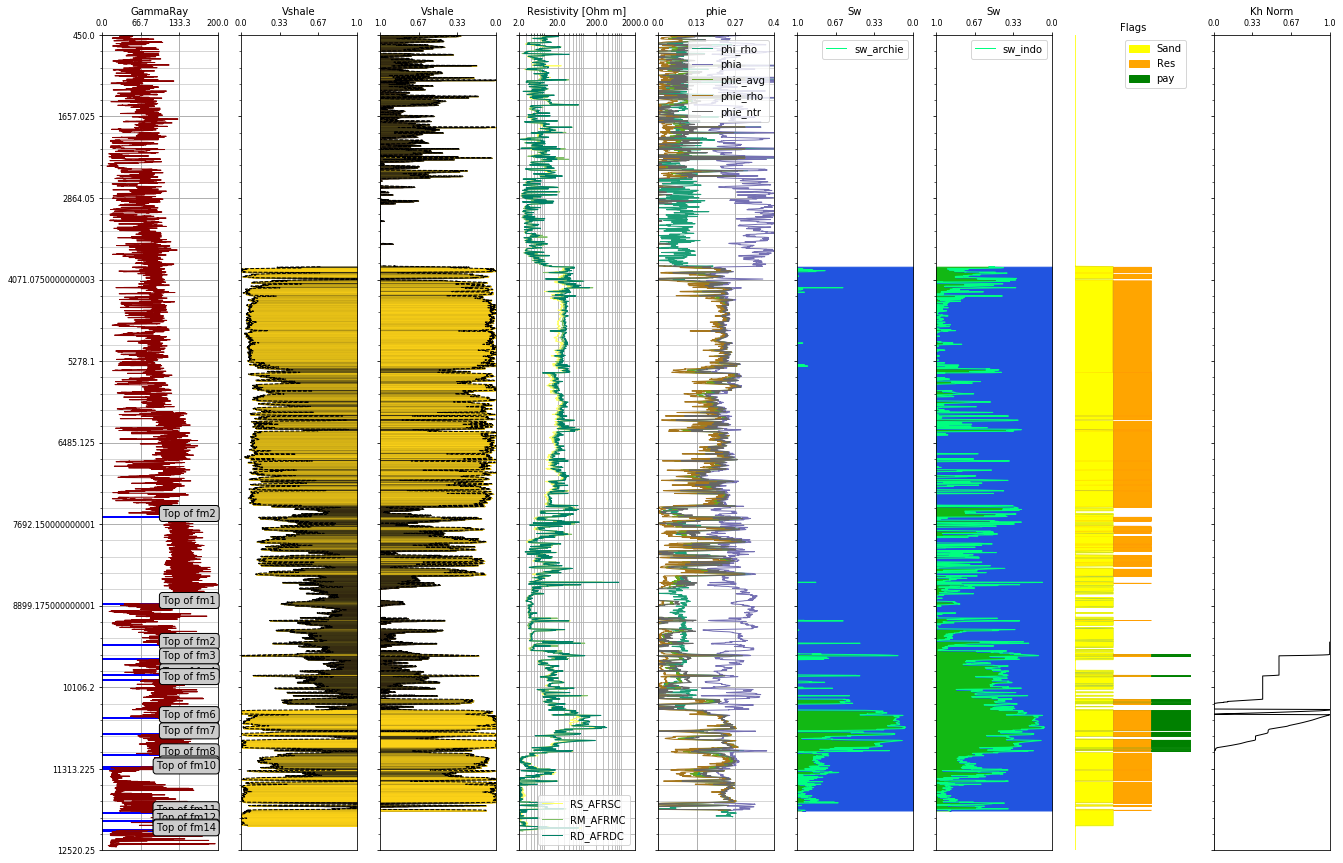

In [35]:
From = 10800
To = 12520

fig, ax = plt.subplots(1,9, figsize=(22,15))
tk.grtrack(logs,gr='DGRCC', gr_max=200, ax=ax[0], fm=tops, 
           fm_kw={'ann':True,'color':'blue', 'linewidth':2}, 
           gr_kw={'linewidth':1})

tk.vshtrack(logpt,vsh='vsh_gr',ax=ax[1],fill=True, inverse=False,lims=[From,To])
tk.vshtrack(logpt,vsh='vsh_dn',ax=ax[2],fill=True, inverse=True,lims=[From,To])
tk.restrack(logs, res=['RS_AFRSC', 'RM_AFRMC', 'RD_AFRDC'], ax=ax[3], res_range=[2,2000],lims=[From,To])
tk.swtrack(logpt, sw=['sw_archie'],ax=ax[5], fill=True,lims=[From,To])
tk.swtrack(logpt, sw=['sw_indo'],ax=ax[6], fill=True,lims=[From,To])
tk.phietrack(logpt,phi=['phi_rho', 'phia', 'phie_avg','phie_rho', 'phie_ntr'], ax=ax[4],lims=[From,To])
tk.flagtrack(logpt, sand='sand_flag',res='reservoir_flag',pay='pay_flag', ax=ax[7], legend=True,lims=[From,To])
tk.khtrack(logpt, kh='kh_norm', ax=ax[8], fill=False,lims=[From,To])
#tk.ktrack(logpt,k=['timur'],ax=ax[9],k_range=[0.1,10000])

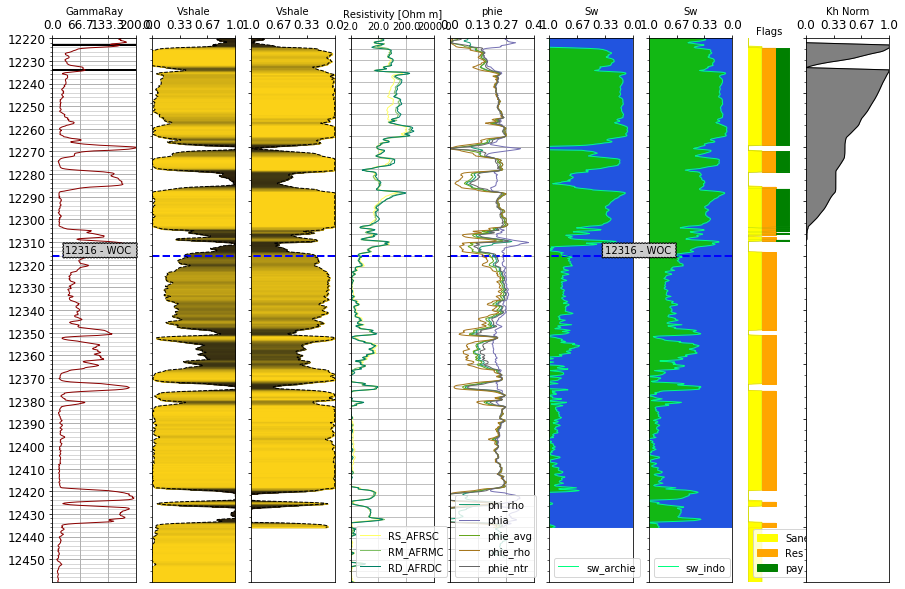

In [36]:
woc = pd.DataFrame({'depth':[12316],'comment':["WOC"]})

From = 12220
To = 12460

fig, ax = plt.subplots(1,9, figsize=(15,10),gridspec_kw={'width_ratios':[1,1,1,1,1,1,1,0.5,1]})
tk.grtrack(logs,gr='DGRCC', gr_max=200, ax=ax[0], fm=tops, 
           fm_kw={'ann':False,'color':'black', 'linewidth':2}, 
           gr_kw={'linewidth':1}, lims=[From,To],steps=[10,2],fontsize=12,correlation=woc,corr_kw={'ann':True, 'color':'blue'})

tk.vshtrack(logpt,vsh='vsh_gr',ax=ax[1],fill=True, inverse=False, lims=[From,To],fontsize=12,correlation=woc,corr_kw={'ann':False, 'color':'blue'})
tk.vshtrack(logpt,vsh='vsh_dn',ax=ax[2],fill=True, inverse=True, lims=[From,To],fontsize=12,correlation=woc,corr_kw={'ann':False, 'color':'blue'})
tk.restrack(logs, res=['RS_AFRSC', 'RM_AFRMC', 'RD_AFRDC'], ax=ax[3], res_range=[2,2000], lims=[From,To],fontsize=10,correlation=woc,corr_kw={'ann':False, 'color':'blue'})
tk.swtrack(logpt, sw=['sw_archie'],ax=ax[5], fill=True, lims=[From,To],fontsize=12,correlation=woc,corr_kw={'ann':False, 'color':'blue'})
tk.swtrack(logpt, sw=['sw_indo'],ax=ax[6], fill=True, lims=[From,To],fontsize=12,correlation=woc,corr_kw={'ann':True, 'color':'blue'})
tk.phietrack(logpt,phi=['phi_rho', 'phia', 'phie_avg','phie_rho', 'phie_ntr'], ax=ax[4], lims=[From,To],fontsize=12,correlation=woc,corr_kw={'ann':False, 'color':'blue'})
tk.flagtrack(logpt, sand='sand_flag',res='reservoir_flag',pay='pay_flag', ax=ax[7], legend=True, lims=[From,To],fontsize=12)
tk.khtrack(logpt, kh='kh_norm', ax=ax[8], lims=[From,To],fontsize=12)
#tk.ktrack(logpt,k=['coates','morris','timur'],ax=ax[9],lims=[From,To], colormap='Blues')

## Add  the petrophysics curves to b2.openlogs

In [37]:
b2.add_to_logs(logpt)


In [38]:
b2.openlog.df().columns

Index(['ROP_ROPA', 'DGRCC', 'R09PC', 'R15PC', 'R27PC', 'R39PC', 'ARH16PC',
       'ARH32PC', 'ARH48PC', 'ARM48PC', 'RM_AFRMC', 'RS_AFRSC', 'RD_AFRDC',
       'ABR', 'RHOB_ALCDLC', 'DCOR_ALDCLC', 'PEF_ALPELC', 'NPHI_TNPS', 'ALHSI',
       'STEMP', 'formation', 'tvd', 'tvdss', 'vsh_gr', 'vsh_dn', 'phi_rho',
       'phia', 'phie_avg', 'phie_rho', 'phie_ntr', 'sw_archie', 'sw_indo',
       'k_timur', 'k_morris', 'k_coates', 'sand_flag', 'reservoir_flag',
       'pay_flag', 'kh', 'kh_norm'],
      dtype='object')

# Take Only one formation

We can compare petrophysical properties between intervals choosen

Two intervals from Fm13 and fm14 were choosen at top of the zones. The main properties like mid points, tickness are estimated. Besides a summary of the petrophysical paremeters can be attached to them

In [39]:
# Create the perforations class
p_tentative= ph.perforations({'md_top':[12224,12234],'md_bottom':[12232,12242]})
type(p_tentative)

reservoirpy.wellpy.path.wells.perforations

In [40]:
# Create the perforations class
p_tentative= ph.perforations({'md_top':[12224,12234],'md_bottom':[12232,12242]})

#Add to the Attribute perforations in the Well object
b2.perforations = p_tentative 

#Estimate tvd and tvdss
b2.to_tvd(which=['perforations'])
b2.to_tvd(which=['perforations'],ss=True)

# Estimate the intervals tick
b2.perforations.get_tick()
b2.perforations.get_mid_point()

,md_top,md_bottom,tvd_top,tvd_bottom,tvd_tick,tvdss_top,tvdss_bottom,md_tick,md_mid_point,tvd_mid_point,tvdss_mid_point
0,12224,12232,11981.381637,11988.972643,7.591006,-11465.601637,-11473.192643,8,12228.0,11985.177140,-11469.397140
1,12234,12242,11990.870394,11998.461400,7.591006,-11475.090394,-11482.681400,8,12238.0,11994.665897,-11478.885897


Once the intervals have been added to the Wells object. You can get a summary of the petrophysical parameters or any curve on the logs. Choose the curves and optionally add an dictionary with the aggregate functions to show

In [41]:
# Get a summary for the intervals of interest
pp = b2.interval_attributes(perforations=True,
                       curves=['vsh_dn','phie_avg','sw_archie','k_timur','k_coates','kh'],
                       aggfunc={'vsh_dn':'mean','phie_avg':['min','max','mean'],
                               'sw_archie':['min','max','mean'],'k_coates':['min','max','mean'],
                               'kh':'sum'})
pp

,md_top,md_bottom,tvd_top,tvd_bottom,tvd_tick,tvdss_top,tvdss_bottom,md_tick,md_mid_point,tvd_mid_point,...,"(phie_avg, min)","(phie_avg, max)","(phie_avg, mean)","(sw_archie, min)","(sw_archie, max)","(sw_archie, mean)","(k_coates, min)","(k_coates, max)","(k_coates, mean)","(kh, sum)"
0.0,12224,12232,11981.381637,11988.972643,7.591006,-11465.601637,-11473.192643,8,12228.0,11985.177140,...,0.089359,0.174152,0.150632,0.222784,1.000000,0.321323,5.738459,82.785534,49.892554,732.054260
1.0,12234,12242,11990.870394,11998.461400,7.591006,-11475.090394,-11482.681400,8,12238.0,11994.665897,...,0.169648,0.236727,0.218984,0.083474,0.456206,0.160189,74.547543,282.637857,212.089875,3620.486361


In [42]:
b2.perforations

,md_top,md_bottom,tvd_top,tvd_bottom,tvd_tick,tvdss_top,tvdss_bottom,md_tick,md_mid_point,tvd_mid_point,...,"(phie_avg, min)","(phie_avg, max)","(phie_avg, mean)","(sw_archie, min)","(sw_archie, max)","(sw_archie, mean)","(k_coates, min)","(k_coates, max)","(k_coates, mean)","(kh, sum)"
0.0,12224,12232,11981.381637,11988.972643,7.591006,-11465.601637,-11473.192643,8,12228.0,11985.177140,...,0.089359,0.174152,0.150632,0.222784,1.000000,0.321323,5.738459,82.785534,49.892554,732.054260
1.0,12234,12242,11990.870394,11998.461400,7.591006,-11475.090394,-11482.681400,8,12238.0,11994.665897,...,0.169648,0.236727,0.218984,0.083474,0.456206,0.160189,74.547543,282.637857,212.089875,3620.486361


In [43]:
# Get a summary for the intervals of interest

perf_main = ph.perforations({'md_top':[12290],'md_bottom':[12300]})

pp = b2.interval_attributes(intervals = perf_main,
                       curves=['vsh_dn','phie_avg','sw_archie','k_timur','k_coates','kh'],
                       aggfunc={'vsh_dn':'mean','phie_avg':['min','max','mean'],
                               'sw_archie':['min','max','mean'],'k_coates':['min','max','mean'],
                               'kh':'sum'})
pp

,md_top,md_bottom,"(vsh_dn, mean)","(phie_avg, min)","(phie_avg, max)","(phie_avg, mean)","(sw_archie, min)","(sw_archie, max)","(sw_archie, mean)","(k_coates, min)","(k_coates, max)","(k_coates, mean)","(kh, sum)"
0.0,12290,12300,0.0,0.224555,0.259943,0.23975,0.165029,0.330869,0.27847,228.84233,410.916387,300.871033,6599.400677


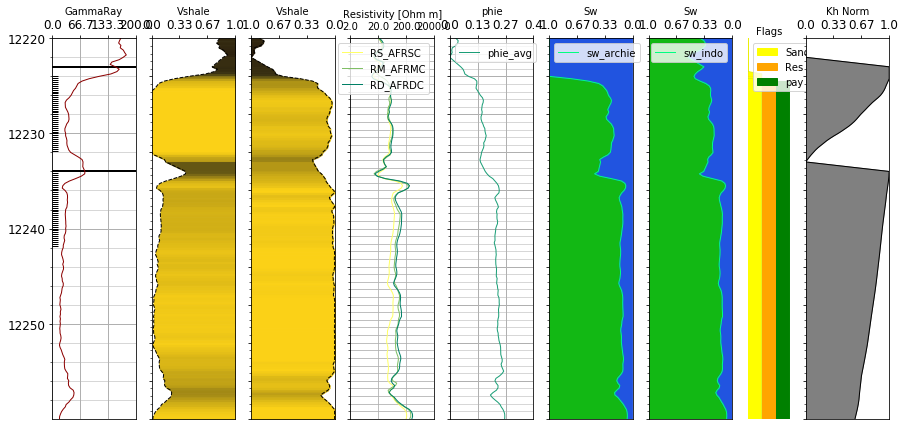

In [44]:
From = 12220
To = 12260

fig, ax = plt.subplots(1,9, figsize=(15,7),gridspec_kw={'width_ratios':[1,1,1,1,1,1,1,0.5,1]})
tk.grtrack(logs,gr='DGRCC', gr_max=200, ax=ax[0], fm=tops[(tops['md_top']>From)&(tops['md_top']<To)], 
           fm_kw={'ann':False,'color':'black', 'linewidth':2}, 
           gr_kw={'linewidth':1}, lims=[From,To],steps=[10,2],fontsize=12, perf=b2.perforations)

tk.vshtrack(logpt,vsh='vsh_gr',ax=ax[1],fill=True, inverse=False, lims=[From,To],fontsize=12)
tk.vshtrack(logpt,vsh='vsh_dn',ax=ax[2],fill=True, inverse=True, lims=[From,To],fontsize=12)
tk.restrack(logs, res=['RS_AFRSC', 'RM_AFRMC', 'RD_AFRDC'], ax=ax[3], res_range=[2,2000], lims=[From,To],fontsize=10,)
tk.swtrack(logpt, sw=['sw_archie'],ax=ax[5], fill=True, lims=[From,To],fontsize=12)
tk.swtrack(logpt, sw=['sw_indo'],ax=ax[6], fill=True, lims=[From,To],fontsize=12)
tk.phietrack(logpt,phi=['phie_avg'], ax=ax[4], lims=[From,To],fontsize=12)
tk.flagtrack(logpt, sand='sand_flag',res='reservoir_flag',pay='pay_flag', ax=ax[7], legend=True, lims=[From,To],fontsize=12)
tk.khtrack(logpt, kh='kh_norm', ax=ax[8], lims=[From,To],fontsize=12)

## Initial pressure and Productivity Index is estimated

Taking the reservoir pressure at datum to the mid perforations points. 

The Productivity Index is calculated with the fluids properties as well as the Inflow curve

In [45]:
# Inflow curves

pi.oil_j(mu=4.8,bo=1.1,kh=5000,re=1490,rw=0.58,s=0)



0.9441348155850959

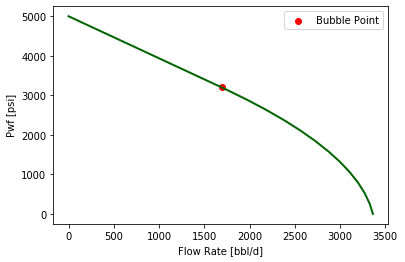

In [46]:
in1 = pi.oil_inflow(pr=5000,j=0.94, pb=3200,n=20)
in1.plot()

In [47]:
in1.pwf_to_flow([4000,1000])

array([ 940.        , 3126.66451216])

In [48]:
in1.flow_to_pwf([2500,1000])

array([2199.0724039 , 3936.17021277])

In [49]:
in1.flow_to_dd([2500,1000])

array([2800.9275961 , 1063.82978723])

In [50]:
in1.dd_to_flow([3000])

array([2629.83010157])

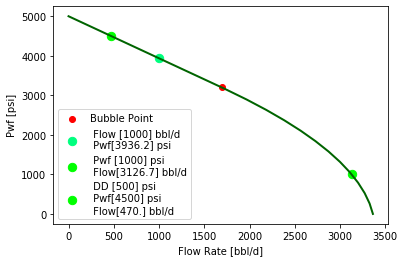

In [51]:
in1.plot(flow=[1000], dd=500, pwf=[1000])

In [52]:
pr = 4970
datum = -11371

b2.perforations['mu'] = 4.8
b2.perforations['bo'] = 1.240
b2.perforations['go'] = 0.8403*0.433
b2.perforations['gw'] = 0.433
b2.perforations['pb'] = 3241
b2.perforations['pr'] = b2.perforations.apply(lambda x: pr + ((datum-x['tvdss_mid_point'])*((x['gw']*x[('sw_archie', 'max')])+(x['go']*(1-x[('sw_archie', 'max')])))),axis=1)


b2.perforations['j'] = b2.perforations.apply(lambda x: pi.oil_j(x['mu'],x['bo'],kh=x[('kh', 'sum')]), axis=1)
b2.perforations['inflow'] = b2.perforations.apply(lambda x: pi.oil_inflow(pr=x['pr'],j=x['j'],pb=x['pb']),axis=1)
b2.perforations

,md_top,md_bottom,tvd_top,tvd_bottom,tvd_tick,tvdss_top,tvdss_bottom,md_tick,md_mid_point,tvd_mid_point,...,"(k_coates, mean)","(kh, sum)",mu,bo,go,gw,pb,pr,j,inflow
0.0,12224,12232,11981.381637,11988.972643,7.591006,-11465.601637,-11473.192643,8,12228.0,11985.177140,...,49.892554,732.054260,4.8,1.24,0.36385,0.433,3241,5012.605962,0.122625,Oil Inflow: \n Reservoir Pressure: ...
1.0,12234,12242,11990.870394,11998.461400,7.591006,-11475.090394,-11482.681400,8,12238.0,11994.665897,...,212.089875,3620.486361,4.8,1.24,0.36385,0.433,3241,5012.657714,0.606460,Oil Inflow: \n Reservoir Pressure: ...


## Plot inflow curves

The difference in the petrophysical perameters calculated show a difference in productivity

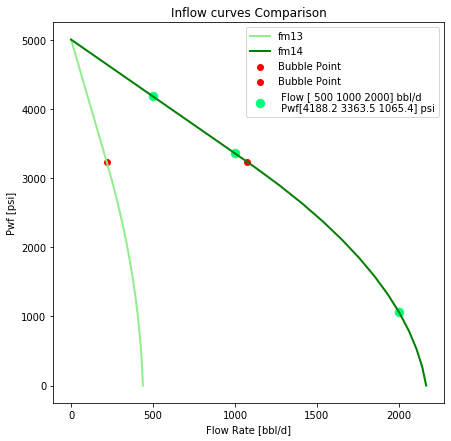

In [53]:
fig, ax = plt.subplots(1,1, figsize=(7,7))

b2.perforations['inflow'][0.0].plot(ax=ax, label='fm13',color='lightgreen')
b2.perforations['inflow'][1.0].plot(ax=ax, label='fm14', color='green',flow=[500,1000,2000])
ax.set_title('Inflow curves Comparison')
ax.legend()

## Relative Permeabilities and fractional flow

Taken from Dynamic model Presentation

The fractional flow curve is estimated based on the relative permeabilities used in the reservoir simulation model to predict the initial water cut

In [54]:
rel_perm = pd.DataFrame({'sw':[0.1,0.15,0.21,0.26,0.31,0.37,0.42,0.48,0.53,0.58,0.64,0.69,0.74,0.8,0.85,1.0],
                        'krw':[0,0,0,0,0,0,0.01,0.01,0.02,0.04,0.07,0.12,0.19,0.28,0.40,0.40],
                        'kro':[1,0.89,0.78,0.68,0.58,0.49,0.41,0.33,0.26,0.19,0.13,0.09,0.04,0.01,0,0]})
rel_perm = rel_perm.set_index('sw')

### Fractional Flow Initial Water Cut

divide by zero encountered in double_scalars


Text(0, 0.5, 'Fw')

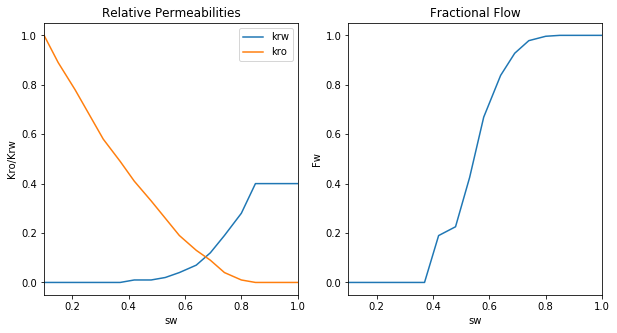

In [55]:
muo=4.8
muw=0.5

rel_perm['ff'] = rel_perm.apply(lambda x: 1/(1+((x['kro']*muw)/((x['krw']*muo)))),axis=1)

fig,ax = plt.subplots(1,2, figsize=(10,5))

rel_perm[['krw','kro']].plot(ax=ax[0])
ax[0].set_title('Relative Permeabilities')
ax[0].set_ylabel('Kro/Krw')
rel_perm['ff'].plot(ax=ax[1])
ax[1].set_title('Fractional Flow')
ax[1].set_ylabel('Fw')

In [56]:
b2.perforations[['md_top','md_bottom',('sw_archie','mean')]]

,md_top,md_bottom,"(sw_archie, mean)"
0.0,12224,12232,0.321323
1.0,12234,12242,0.160189


According with the relative permebilities and the average water saturation in the intervals the initial water cut would be very low